# Matrix multiplication

This example demonstrates how to perform
general matrix multiplication using Nengo.
The matrix can change during the computation,
which makes it distinct from doing static matrix multiplication
with neural connection weights (as done in all neural networks).

Note that the order of operands in matrix multiplication matters.
We will be computing $A \cdot B$ which is equivalent to $(B \cdot A)^{\top}$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

In [2]:
N = 100
Amat = np.asarray([[.5, -.5], [-.2, .3]])
Bmat = np.asarray([[0.58, -1.], [.7, 0.1]])

# Values should stay within the range (-radius, radius)
radius = 1

model = nengo.Network(label='Matrix Multiplication', seed=123)
with model:
    # Make 2 EnsembleArrays to store the input
    A = nengo.networks.EnsembleArray(N, Amat.size, radius=radius)
    B = nengo.networks.EnsembleArray(N, Bmat.size, radius=radius)

    # connect inputs to them so we can set their value
    inputA = nengo.Node(Amat.ravel())
    inputB = nengo.Node(Bmat.ravel())
    nengo.Connection(inputA, A.input)
    nengo.Connection(inputB, B.input)
    A_probe = nengo.Probe(A.output, sample_every=0.01, synapse=0.01)
    B_probe = nengo.Probe(B.output, sample_every=0.01, synapse=0.01)

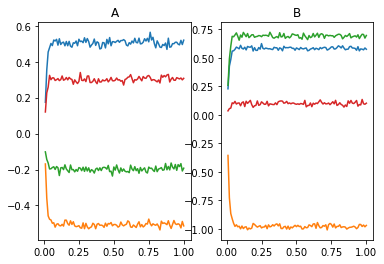

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(1)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('A')
plt.plot(sim.trange(sample_every=0.01), sim.data[A_probe])
plt.subplot(1, 2, 2)
plt.title('B')
plt.plot(sim.trange(sample_every=0.01), sim.data[B_probe]);

In [4]:
with model:
    # The C matrix is composed of populations that each contain
    # one element of A and one element of B.
    # These elements will be multiplied together in the next step.

    # The appropriate encoders make the multiplication more accurate
    # Check the "multiplication" example to see how multiplication
    # can be implemented in neurons.
    c_size = Amat.size * Bmat.shape[1]
    C = nengo.networks.Product(N, dimensions=c_size)

# Determine the transformation matrices to get the correct pairwise
# products computed.  This looks a bit like black magic but if
# you manually try multiplying two matrices together, you can see
# the underlying pattern.  Basically, we need to build up D1*D2*D3
# pairs of numbers in C to compute the product of.  If i,j,k are the
# indexes into the D1*D2*D3 products, we want to compute the product
# of element (i,j) in A with the element (j,k) in B.  The index in
# A of (i,j) is j+i*D2 and the index in B of (j,k) is k+j*D3.
# The index in C is j+k*D2+i*D2*D3.
transformA = np.zeros((c_size, Amat.size))
transformB = np.zeros((c_size, Bmat.size))

for i in range(Amat.shape[0]):
    for j in range(Amat.shape[1]):
        for k in range(Bmat.shape[1]):
            c_index = (j + k * Amat.shape[1] + i * Bmat.size)
            transformA[c_index][j + i * Amat.shape[1]] = 1
            transformB[c_index][k + j * Bmat.shape[1]] = 1

print("A->C")
print(transformA)
print("B->C")
print(transformB)

with model:
    nengo.Connection(A.output, C.input_a, transform=transformA)
    nengo.Connection(B.output, C.input_b, transform=transformB)
    C_probe = nengo.Probe(C.output, sample_every=0.01, synapse=0.01)

A->C
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
B->C
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [5]:
# Look at C
with nengo.Simulator(model) as sim:
    sim.run(1)

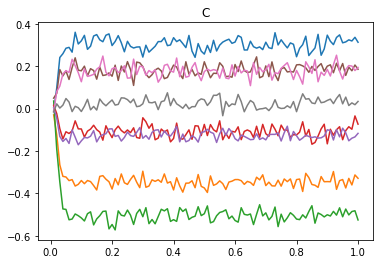

In [6]:
plt.figure()
plt.plot(sim.trange(sample_every=0.01), sim.data[C_probe])
plt.title('C');

In [7]:
with model:
    # Now do the appropriate summing
    D = nengo.networks.EnsembleArray(
        N, n_ensembles=Amat.shape[0] * Bmat.shape[1], radius=radius)

# The mapping for this transformation is much easier, since we want to
# combine D2 pairs of elements (we sum D2 products together)
transformC = np.zeros((D.dimensions, c_size))
for i in range(c_size):
    transformC[i // Bmat.shape[0]][i] = 1
print("C->D")
print(transformC)

with model:
    nengo.Connection(C.output, D.input, transform=transformC)
    D_probe = nengo.Probe(D.output, sample_every=0.01, synapse=0.01)

C->D
[[1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]]


In [8]:
with nengo.Simulator(model) as sim:
    sim.run(1)

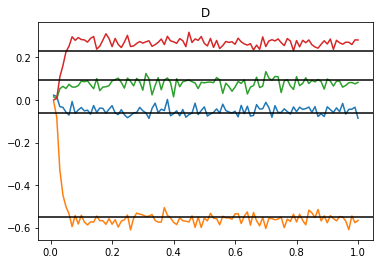

In [9]:
plt.figure()
plt.plot(sim.trange(sample_every=0.01), sim.data[D_probe])
for d in np.dot(Amat, Bmat).flatten():
    plt.axhline(d, color='k')
plt.title("D");